# PPO Trading Agent — Training & Evaluation

Train a custom PPO agent on 20 S&P 500 stocks, visualize learning curves, and evaluate on held-out test data.

In [3]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Ensure local packages are importable
sys.path.insert(0, os.path.abspath('.'))

from src.data_loader import process_data_with_indicators, split_data
from envs.naive_env import AlphaTradeEnv
from agent.ppo import PPO

## 1. Load & Process Data

In [4]:
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA',
    'META', 'TSLA', 'NFLX', 'UNH', 'JNJ',
    'V', 'JPM', 'WMT', 'MA', 'PG',
    'HD', 'DIS', 'BAC', 'XOM', 'CVX'
]

# Load from local CSVs (already downloaded via load_data.ipynb)
stock_data = {}
for ticker in tickers:
    df = pd.read_csv(f'data/{ticker}.csv', skiprows=2, index_col='Date', parse_dates=True)
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    stock_data[ticker] = df

# Add technical indicators
stock_data = process_data_with_indicators(stock_data)

# Split: train (2009-2019), val (2020), test (2021-2025)
# Your choice of split, feel free to change in src/data_loader.py
training_data, validation_data, test_data = split_data(stock_data)

## 2. Train PPO Agent

In [5]:
# Create training environment
train_env = AlphaTradeEnv(training_data)
print(f"Observation space: {train_env.observation_space.shape}")
print(f"Action space:      {train_env.action_space.shape}")
print(f"Max steps:         {train_env.max_steps}")

# Initialize PPO
ppo = PPO(
    env=train_env,
    lr=3e-4,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    n_epochs=10,
    batch_size=64,
    ent_coef=0.01,
    vf_coef=0.5,
)

# Train
N_ITERATIONS = 10
STEPS_PER_ITER = 2048
training_stats = ppo.train(n_iterations=N_ITERATIONS, steps_per_iter=STEPS_PER_ITER)

Observation space: (263,)
Action space:      (20,)
Max steps:         1490
Iteration 10/10 | Mean Reward: -0.31 | Policy Loss: -0.0752 | Value Loss: 0.2613 | Entropy: 29.4653


In [6]:
print(training_stats)

{'iterations': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'mean_rewards': [-0.18911855849045506, -0.28856263000213367, -0.31335305160110316, -0.22544029445114427, -0.19052103773284268, -0.3012286878489291, -0.3125601390585604, -0.24783996758961435, -0.2553985162492125, -0.31355353259490537], 'policy_losses': [-0.060363718219741715, -0.05987962067592889, -0.055395745945861566, -0.053135237761307505, -0.05031583235249855, -0.0701295642007608, -0.06053189464728348, -0.05693738746340386, -0.07730798186094034, -0.0751535589719424], 'value_losses': [0.8641982275992632, 0.6708504947368056, 0.5644847858930007, 0.23333001770079137, 0.39098956184461714, 0.29709079139865935, 0.2548027421114966, 0.3019648670218885, 0.48317524963058534, 0.26131764422170817], 'entropies': [28.456472688913344, 28.542850136756897, 28.656285673379898, 28.78111629486084, 28.89770176410675, 29.029777550697325, 29.11743673682213, 29.25624194741249, 29.351991468667983, 29.465301710367203]}


## 3. Training Curves

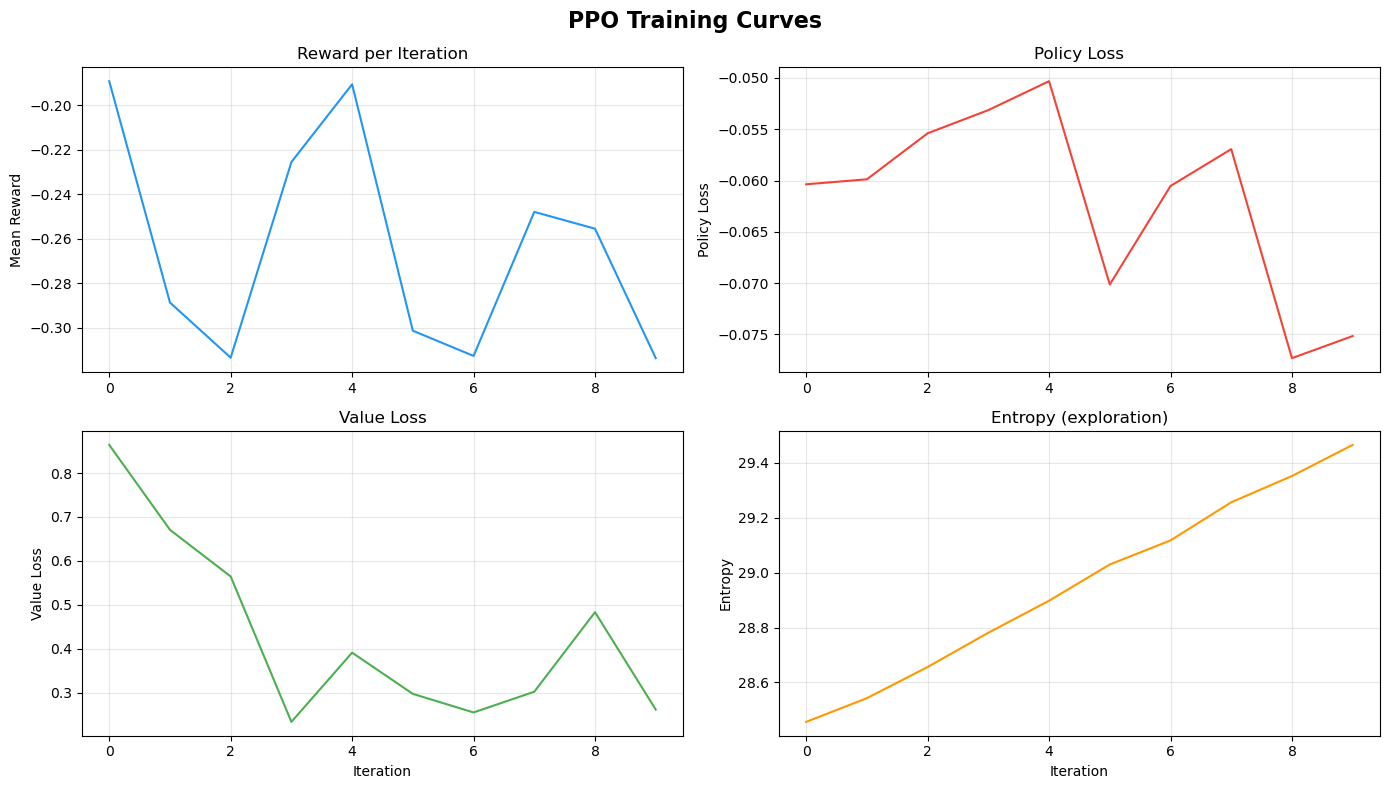

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('PPO Training Curves', fontsize=16, fontweight='bold')

iters = training_stats['iterations']

# Mean Reward
ax = axes[0, 0]
ax.plot(iters, training_stats['mean_rewards'], color='#2196F3')
ax.set_ylabel('Mean Reward')
ax.set_title('Reward per Iteration')
ax.grid(alpha=0.3)

# Policy Loss
ax = axes[0, 1]
ax.plot(iters, training_stats['policy_losses'], color='#F44336')
ax.set_ylabel('Policy Loss')
ax.set_title('Policy Loss')
ax.grid(alpha=0.3)

# Value Loss
ax = axes[1, 0]
ax.plot(iters, training_stats['value_losses'], color='#4CAF50')
ax.set_ylabel('Value Loss')
ax.set_xlabel('Iteration')
ax.set_title('Value Loss')
ax.grid(alpha=0.3)

# Entropy
ax = axes[1, 1]
ax.plot(iters, training_stats['entropies'], color='#FF9800')
ax.set_ylabel('Entropy')
ax.set_xlabel('Iteration')
ax.set_title('Entropy (exploration)')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Evaluate on Test Data

In [10]:
def evaluate_agent(ppo_agent, stock_data, label='Test'):
    """Run PPO on an environment and track net worth over time."""
    env = AlphaTradeEnv(stock_data)
    state, _ = env.reset()
    
    net_worths = [env.initial_balance]
    balances = [env.balance]
    steps = [0]
    
    for step in range(env.max_steps):
        action = ppo_agent.predict(state)
        state, reward, done, truncated, _ = env.step(action)
        
        net_worths.append(env.net_worth)
        balances.append(env.balance)
        steps.append(step + 1)
        
        if done or truncated:
            break
    
    # Get dates from one of the tickers
    sample_ticker = list(stock_data.keys())[0]
    dates = stock_data[sample_ticker].index[:len(net_worths)]
    
    total_return = (net_worths[-1] - net_worths[0]) / net_worths[0] * 100
    returns = np.diff(net_worths) / np.array(net_worths[:-1])
    sharpe = np.mean(returns) / (np.std(returns) + 1e-8) * np.sqrt(252)
    
    peak = np.maximum.accumulate(net_worths)
    max_dd = np.max((peak - net_worths) / peak) * 100
    
    print(f"\n{'='*50}")
    print(f"{label} Results ({len(net_worths)-1} steps)")
    print(f"{'='*50}")
    print(f"Final Net Worth:  ${net_worths[-1]:,.2f}")
    print(f"Total Return:     {total_return:+.2f}%")
    print(f"Sharpe Ratio:     {sharpe:.3f}")
    print(f"Max Drawdown:     {max_dd:.2f}%")
    
    return {'net_worths': net_worths, 'dates': dates, 'returns': returns,
            'total_return': total_return, 'sharpe': sharpe, 'max_dd': max_dd}

# Evaluate on validation and test sets
val_results = evaluate_agent(ppo, validation_data, label='Validation')
test_results = evaluate_agent(ppo, test_data, label='Test')


Validation Results (252 steps)
Final Net Worth:  $183,265.08
Total Return:     +83.27%
Sharpe Ratio:     1.696
Max Drawdown:     29.56%

Test Results (1004 steps)
Final Net Worth:  $170,594.23
Total Return:     +70.59%
Sharpe Ratio:     0.600
Max Drawdown:     63.54%


## 5. Net Worth Over Time

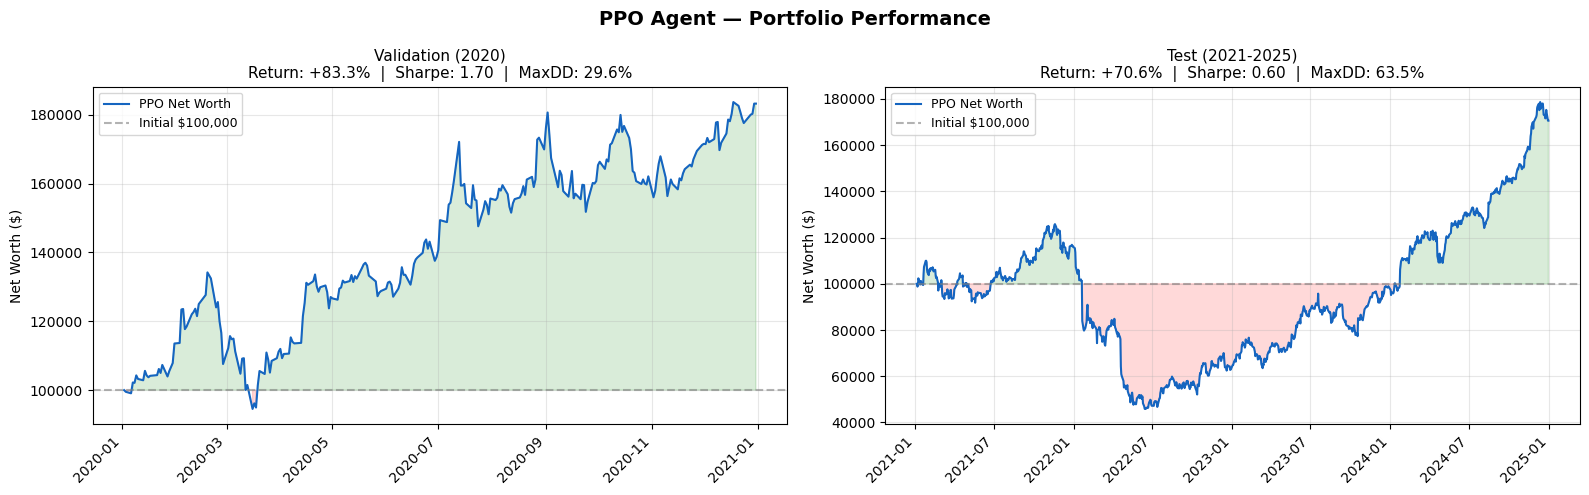

In [11]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
initial = 100000

for ax, res, title in [(axes[0], val_results, 'Validation (2020)'),
                        (axes[1], test_results, 'Test (2021-2025)')]:
    dates = res['dates']
    nw = np.array(res['net_worths'][:len(dates)])
    
    ax.plot(dates, nw, color='#1565C0', linewidth=1.5, label='PPO Net Worth')
    ax.axhline(initial, color='gray', linestyle='--', alpha=0.6, label=f'Initial ${initial:,}')
    ax.fill_between(dates, initial, nw, where=nw >= initial, alpha=0.15, color='green')
    ax.fill_between(dates, initial, nw, where=nw < initial, alpha=0.15, color='red')
    
    ax.set_title(f'{title}\nReturn: {res["total_return"]:+.1f}%  |  Sharpe: {res["sharpe"]:.2f}  |  MaxDD: {res["max_dd"]:.1f}%',
                 fontsize=11)
    ax.set_ylabel('Net Worth ($)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('PPO Agent — Portfolio Performance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Save Model

In [12]:
os.makedirs('models', exist_ok=True)

save_path = 'models/ppo_trading.pt'
torch.save({
    'policy_state_dict': ppo.policy.state_dict(),
    'optimizer_state_dict': ppo.optimizer.state_dict(),
    'training_stats': training_stats,
    'obs_shape': train_env.observation_space.shape[0],
    'action_shape': train_env.action_space.shape[0],
}, save_path)